# Test methods for accessing CESM1 and CMIP6 output via Pangeo methodologies
## February 2024

In [2]:
# Packages needed generally
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs
import dask

### Example 1: CESM1 Large Ensemble

Here I will demonstrate how to extract information from the CESM1 Large Ensemble hosted on Amazon Web Services, following similar steps as 

https://github.com/dianaxnav/cesm-lens-aws-dn/tree/main

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files. 

Things to note:
- The grid file used here is only for OCEAN variables; the atmosphere and land have different lat and lon information.
- For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".

In [3]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

The name of the ocean temperature variable is "TEMP"; a full list of CESM-specific variable names can be found here:

https://www.cesm.ucar.edu/community-projects/lens2/output-variables

In [4]:
# Search for the TEMP variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,CTRL,monthly,60.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-TE...
2,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
3,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [5]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members = 
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)

col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [6]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/p_park/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



Dataset dictionary keys:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])


In [7]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)
grid

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60)
Coordinates: (12/63)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                    ...
    vonkar                float64 ...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg
Data variables:
    *empty*

In [8]:
# Define Xarray datasets corresponding to the two experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]

In [9]:
ds_20C_mean=ds_20C.mean(dim="member_id")
ds_20C_mean

<xarray.Dataset>
Dimensions:     (time: 1032, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>

In [10]:
#ds_20C_mean.TEMP.sel(time=slice("1950", "2000"))
ds_20C_mean.sel(time=slice("1950", "2000"))

<xarray.Dataset>
Dimensions:     (time: 612, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * time        (time) object 1950-01-16 12:00:00 ... 2000-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(612, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 384, 320), meta=np.ndarray>

<Axes: >

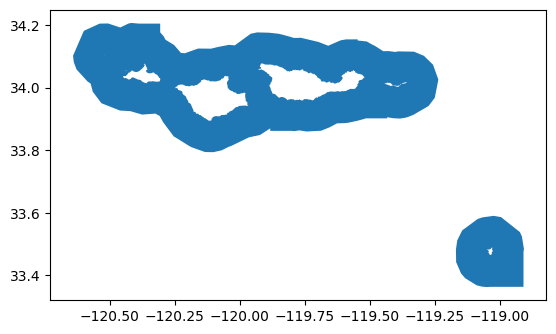

In [11]:
# path to channel island shapefile
cinms = 'cinms_py'

# Read the shapefile
pts = gpd.read_file(cinms)

# Read the shapefile
cinms_shape = gpd.read_file(cinms).to_crs(4326)

cinms_shape.plot()

In [12]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(30, 20), 
#                        subplot_kw={'projection': ccrs.PlateCarree()})

# # Plot the Xarray dataset as background
# ds_20C_mean['TEMP'].plot(ax=ax, 
#          transform=ccrs.PlateCarree())

# # Set the extent of the plot based on the shapefile bounding box
# ax.set_extent([cinm_0, cinm_2, cinm_1, cinm_3])

# # Plot the shapefile
# cinms_shape.plot(ax=ax, facecolor = "none")

# # Add gridlines
# ax.gridlines(draw_labels=True)

# # Add a title
# ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature')

# # Show the plot
# plt.show()


In [ ]:
# Merge the datasets
merged_dataset = xr.merge([grid, ds_20C])
ds_20C_merged_mean=merged_dataset.mean(dim="member_id")
#when TEMP is added in code
#test = ds_20C_merged_mean.TEMP.sel(time=slice("1950", "2000"))
#when TEMP is not added in code
test = ds_20C_merged_mean.sel(time=slice("1950", "2000"))
test

In [17]:
#subset the region box
regbox=[-40, 40, 90, 300]
# Read in specified region
mask_lon = (test.TLONG >= regbox[2]) & (test.TLONG <= regbox[3])
mask_lat = (test.TLAT >= regbox[0]) & (test.TLAT <= regbox[1])
temp=test.where(mask_lon.compute() & mask_lat.compute(), drop=True)
temp

<xarray.Dataset>
Dimensions:               (time: 612, z_t: 60, nlat: 228, nlon: 186, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60, d2: 2)
Coordinates: (12/65)
    ANGLE                 (nlat, nlon) float64 0.0 0.0 0.0 ... -0.03796 -0.03605
    ANGLET                (nlat, nlon) float64 0.0 0.0 0.0 ... -0.03829 -0.03641
    DXT                   (nlat, nlon) float64 9.625e+06 9.625e+06 ... 9.398e+06
    DXU                   (nlat, nlon) float64 9.662e+06 9.662e+06 ... 9.365e+06
    DYT                   (nlat, nlon) float64 5.94e+06 5.94e+06 ... 4.777e+06
    DYU                   (nlat, nlon) float64 5.94e+06 5.94e+06 ... 4.765e+06
    ...                    ...
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * time                  (time) object 1950-01-16 12:00:00 ... 2000-12-16 12...
    time_bound            (time, d2) object dask.array<chunksize=(612, 2), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg, d2
Data variables:
    TEMP                  (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 228, 186), meta=np.ndarray>

Where I am getting the info to transform the data:
https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates?rq=1
maybe not useful but can go back to it cause it could help

In [30]:
#find additional information on the coordinates
print(temp.TLONG.attrs)
print(temp.TLAT.attrs)


{'long_name': 'array of t-grid longitudes', 'units': 'degrees_east'}
{'long_name': 'array of t-grid latitudes', 'units': 'degrees_north'}


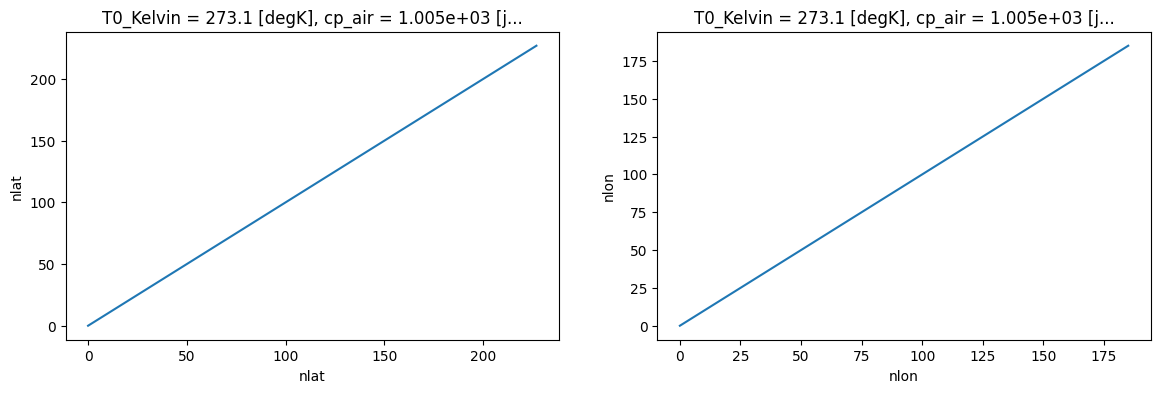

In [ ]:
#just plot these coordinates to have an idea of what they look like
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
temp.TLONG.plot(ax=ax1)
temp.TLAT.plot(ax=ax2)

#or
#temp.nlat or temp.nlon for the plot part

In [ ]:
temp.TEMP.plot(x='nlat', y='nlon')

In [ ]:
# Define the coordinates of the sanctuary boundaries
sanctuary_boundaries = {
    'TLAT': slice(-120.64208, -118.90879),  # Longitude range
    'TLONG': slice(33.36241, 34.20492)       # Latitude range
}

# Subset the merged dataset to include data within the sanctuary boundaries
ds_20C_sanctuary = temp.sel(**sanctuary_boundaries)

# Now you can continue analyzing or plotting the data within the sanctuary boundaries


In [22]:
#probably correct way to do it?
# Define the coordinates of the sanctuary boundaries
sanctuary_boundaries = {
    'nlat': slice(200,300),  # Longitude range
    'nlon': slice(200,260)       # Latitude range
}

# Subset the merged dataset to include data within the sanctuary boundaries
ds_20C_sanctuary = ds_20C_merged_mean.sel(**sanctuary_boundaries)

# Now you can continue analyzing or plotting the data within the sanctuary boundaries
ds_20C_sanctuary.plot()

<xarray.Dataset>
Dimensions:               (nlat: 100, nlon: 60, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60, time: 1032, d2: 2)
Coordinates: (12/65)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(100, 60), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(100, 60), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(100, 60), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(100, 60), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(100, 60), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(100, 60), meta=np.ndarray>
    ...                    ...
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * time                  (time) object 1920-01-16 12:00:00 ... 2005-12-16 12...
    time_bound            (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg, d2
Data variables:
    TEMP                  (time, z_t, nlat, nlon) float32 dask.array<chunksize=(6, 60, 100, 60), meta=np.ndarray>

(array([84488., 30781., 44920., 50679., 24909., 17739., 16692., 14863.,
        15240., 20308.]),
 array([ 0.61326492,  3.31204748,  6.01082993,  8.70961189, 11.40839481,
        14.10717678, 16.8059597 , 19.50474167, 22.20352364, 24.90230751,
        27.60108948]),
 <BarContainer object of 10 artists>)

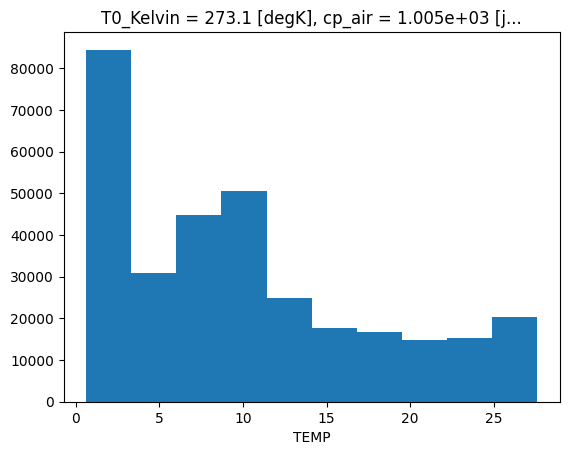

In [41]:
ds_20C_sanctuary_mean = ds_20C_sanctuary.TEMP.sel(time=slice("1950", "2000"))
ds_20C_sanctuary_mean

test_2000 = ds_20C_sanctuary_mean.sel(time='2000-03')
#test_2000
test_2000.squeeze().plot()


NOTE: 
if the variable in interest is taken out, then it plots a bar graph (which i think is the 'vertical profile')

### Example 2: CMIP6

Now I'll do the same thing for the multi-model CMIP6 database, following procedures similar to

https://github.com/pangeo-data/pangeo-cmip6-examples/blob/master/basic_search_and_load.ipynb

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

In [ ]:
# Locate monthly sea surface temperature (tos) from all simulations of the historical period
df_ta = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'historical'")
df_ta

In [ ]:
# Get only information for a specific model: say, CanESM5
df_ta_canesm5 = df_ta.query('source_id == "CanESM5"')
df_ta_canesm5

In [ ]:
# create login credentials, for accessing file system anonymously: this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

In [ ]:
# get all paths to the relevant datasets
zstore = df_ta_canesm5.zstore

# display them
zstore

In [ ]:
# Test data I/O by using the first entry in the data table
zstore = df_ta_canesm5.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

In [ ]:
ds.tos.sel(time='2010-03').squeeze().plot()

In [ ]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(30, 20), 
#                        subplot_kw={'projection': ccrs.PlateCarree()})

# # Plot the Xarray dataset as background
# ds_20C_mean['TEMP'].plot(ax=ax, 
#          transform=ccrs.PlateCarree())

# # Set the extent of the plot based on the shapefile bounding box
# ax.set_extent([cinm_0, cinm_2, cinm_1, cinm_3])

# # Plot the shapefile
# #cinms_shape.plot(ax=ax, facecolor = "none")

# # Add gridlines
# ax.gridlines(draw_labels=True)

# # Add a title
# ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature')

# # Show the plot
# plt.show()

In [ ]:
# Merge the datasets
#merged_dataset = xr.merge([grid] + list(dsets.values()))

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming ds.tos has dimensions (time, lat, lon)
tos_at_specific_time = ds.tos.sel(time='2010-03').mean(dim="time")

# Set up the plot
fig = plt.figure(figsize=[10, 5])
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
# Plot the data
tos_at_specific_time.plot.pcolormesh(ax=ax, cmap='coolwarm', x='longitude', y='latitude')
plt.title('Mean Sea Surface Temperature (March 2010)')
plt.xlabel('Longitude') 
plt.ylabel('Latitude')

plt.show()
